In [1]:

import pandas as pd
pd.set_option('display.max_colwidth', 500)
import numpy as np
import string
import nltk

In [2]:
import wikipediaapi
from nltk.tokenize import sent_tokenize
import re

In [3]:
wiki_wiki = wikipediaapi.Wikipedia('en')

wiki_py = wiki_wiki.page("Pac-Man")

corpus_txt = ""
nr_used_sections = 0

def get_sections(sections, level=0):
    global nr_used_sections
    global corpus_txt
    for s in sections:
        if "references" not in s.title.lower() and "links" not in s.title.lower() and "further" not in s.title.lower() and "notes" not in s.title.lower():
            # keep meaningful characters for topic sentences to be printed..
            txt = re.sub(r"""[^a-zA-Z0-9.,;:!?\s'"-]""", '', s.text)
            txt = re.sub(r'\s+', ' ', txt)
            corpus_txt += txt
            nr_used_sections += 1
        get_sections(s.sections, level + 1)

get_sections(wiki_py.sections)


In [4]:
# check if corpus_data folder exists, if not, create it
import os
folder = "./corpus_data/"
if not os.path.exists(folder):
    os.makedirs(folder)

# check if corpus_data folder is empty, if not, create the corpus data files
# PLEASE NOTICE: if the folder is not empty, the no files will be written
# Sometimes it might be good idea, to delete the "corpus_data" folder...
if len(os.listdir(folder)) == 0:
    for i, sent in enumerate(sent_tokenize(corpus_txt)):
        with open(folder+f'pacman_{i+1}.txt', 'w', encoding="utf-8") as f:
            f.write(sent)

In [5]:
nr_used_sections

18

In [6]:
ts = 2  # the number of topics to start with 2
te = nr_used_sections * 2 + 1 # maximum number of topics to end with

In [7]:
import tmtoolkit
from tmtoolkit.corpus import filter_for_pos
from tmtoolkit.corpus import dtm
from tmtoolkit.corpus import Corpus, print_summary

In [8]:
from copy import copy
corpus = Corpus.from_folder(folder, language='en')
crp = copy(corpus)
print_summary(crp)

Corpus with 202 documents in English
> pacman_104 (32 tokens): II Computing also listed the Atarisoft port tenth ...
> pacman_103 (122 tokens): In addition , Coleco 's tabletop mini - arcade uni...
> pacman_100 (30 tokens): In a 1983 interview , Nakamura said that though he...
> pacman_105 (42 tokens): As of 2016 , all versions of Pac - Man are estimat...
> pacman_1 (22 tokens): Pac - Man is an action maze chase video game ; the...
> pacman_101 (45 tokens): Pac - Man is the best - selling arcade game of all...
> pacman_10 (11 tokens): Eating multiple blue ghosts in succession increase...
> pacman_107 (23 tokens): In 2001 , Pac - Man was voted the greatest video g...
> pacman_102 (52 tokens): Pac - Man and Ms. Pac - Man also topped the US ReP...
> pacman_106 (17 tokens): Pac - Man also won the Video Software Dealers Asso...
(and 192 more documents)
total number of tokens: 6901 / vocabulary size: 1814


In [9]:
from tmtoolkit.corpus import lemmatize, to_lowercase, remove_punctuation, filter_clean_tokens

In [10]:
filter_clean_tokens(crp, remove_shorter_than=2, remove_numbers=True, remove_punct=True, remove_stopwords=True)
to_lowercase(crp)

print_summary(crp)

Corpus with 202 documents in English
> pacman_104 (16 tokens): ii computing listed atarisoft port magazine list a...
> pacman_103 (58 tokens): addition coleco tabletop mini arcade unit sold uni...
> pacman_100 (9 tokens): interview nakamura said expect pac man successful ...
> pacman_105 (16 tokens): versions pac man estimated grossed total revenue p...
> pacman_1 (13 tokens): pac man action maze chase video game player contro...
> pacman_101 (20 tokens): pac man best selling arcade game time surpassing s...
> pacman_10 (8 tokens): eating multiple blue ghosts succession increases p...
> pacman_107 (10 tokens): pac man voted greatest video game time dixons poll...
> pacman_102 (25 tokens): pac man ms. pac man topped replay cocktail arcade ...
> pacman_106 (11 tokens): pac man won video software dealers association vsd...
(and 192 more documents)
total number of tokens: 3246 / vocabulary size: 1403


In [11]:
dtm_, doc_labels, vocab = dtm(crp, return_doc_labels=True, return_vocab=True)

In [13]:
# this isn't the best way to do this, but it works for now :-)
top_n = int(0.01 * dtm_.shape[1])
top_n

14

In [14]:
%%time
import tmtoolkit
from tmtoolkit.topicmod.tm_lda import evaluate_topic_models
from tmtoolkit.topicmod.evaluate import results_by_parameter

const_params = {
    'n_iter': 100,
    'random_state': 42,  # to make results reproducible
    'eta': 0.1,                # sometimes also called "beta"
}

# iterate with different LDA models with different number of topics
var_params = [{'n_topics': k, 'alpha': 1.0/k}
               for k in range(ts, te, 1)]

eval_results = evaluate_topic_models(dtm_,
                                     varying_parameters=var_params,
                                     constant_parameters=const_params,
                                     coherence_mimno_2011_top_n=top_n,
                                     coherence_mimno_2011_include_prob=True,
                                     return_models=True)

Wall time: 25.9 s


c:\Users\marju\anaconda3\lib\site-packages\tmtoolkit\topicmod\visualize.py:833: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(**subplots_adjust_kwargs)


(<Figure size 600x400 with 2 Axes>,
 [array([<AxesSubplot:title={'center':'cao_juan_2009'}>,
         <AxesSubplot:title={'center':'coherence_mimno_2011'}>],
        dtype=object)])

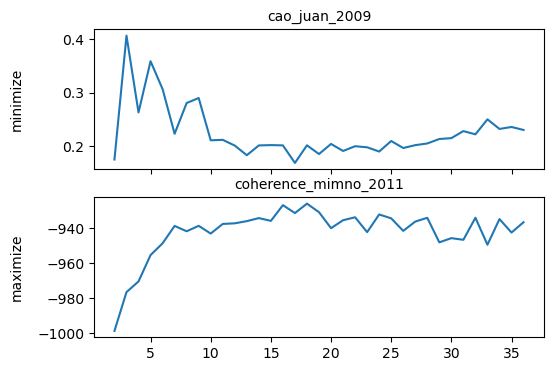

In [15]:
from tmtoolkit.topicmod import tm_lda
from tmtoolkit.topicmod.visualize import plot_eval_results
eval_results_by_topics = results_by_parameter(eval_results, 'n_topics')
plot_eval_results(eval_results_by_topics)

In [16]:
# min value represents the best number of topics
df_cao = pd.DataFrame(results_by_parameter(eval_results, "n_topics", "cao_juan_2009"))
df_cao.columns = ["n_topics", "model"]
df_cao

,n_topics,model
0,17,"{'model': <lda.lda.LDA object at 0x0000026401F415E0>, 'cao_juan_2009': 0.1686769405712388, 'coherence_mimno_2011': -931.2942412395417}"
1,2,"{'model': <lda.lda.LDA object at 0x0000026401F37A90>, 'cao_juan_2009': 0.17507074317983484, 'coherence_mimno_2011': -998.6941630214509}"
2,13,"{'model': <lda.lda.LDA object at 0x0000026401F417F0>, 'cao_juan_2009': 0.1830575476861575, 'coherence_mimno_2011': -935.9056402975717}"
3,19,"{'model': <lda.lda.LDA object at 0x0000026401F41610>, 'cao_juan_2009': 0.18528432195028535, 'coherence_mimno_2011': -930.7882145976638}"
4,24,"{'model': <lda.lda.LDA object at 0x0000026401F41850>, 'cao_juan_2009': 0.18998162135259933, 'coherence_mimno_2011': -932.0867848318676}"
5,21,"{'model': <lda.lda.LDA object at 0x0000026401F414C0>, 'cao_juan_2009': 0.19103144511543485, 'coherence_mimno_2011': -935.383317883482}"
6,26,"{'model': <lda.lda.LDA object at 0x0000026401F418B0>, 'cao_juan_2009': 0.19653701196161835, 'coherence_mimno_2011': -941.468016945973}"
7,23,"{'model': <lda.lda.LDA object at 0x0000026401F417C0>, 'cao_juan_2009': 0.19788386164728272, 'coherence_mimno_2011': -942.2043335843928}"
8,22,"{'model': <lda.lda.LDA object at 0x0000026401F41730>, 'cao_juan_2009': 0.19991247072866491, 'coherence_mimno_2011': -933.6969508046692}"
9,12,"{'model': <lda.lda.LDA object at 0x0000026401F37BE0>, 'cao_juan_2009': 0.20110531310725174, 'coherence_mimno_2011': -937.1477695931472}"


In [17]:

# the greatest value represents the best number of topics (the highest coherence) and is at the end of the list
df_mimno = pd.DataFrame(results_by_parameter(eval_results, "n_topics", "coherence_mimno_2011"), columns=["n_topics", "model"])
df_mimno

,n_topics,model
0,2,"{'model': <lda.lda.LDA object at 0x0000026401F37A90>, 'cao_juan_2009': 0.17507074317983484, 'coherence_mimno_2011': -998.6941630214509}"
1,3,"{'model': <lda.lda.LDA object at 0x0000026401F37AC0>, 'cao_juan_2009': 0.40674653968909585, 'coherence_mimno_2011': -976.5149742944051}"
2,4,"{'model': <lda.lda.LDA object at 0x0000026401F37AF0>, 'cao_juan_2009': 0.2630870438567369, 'coherence_mimno_2011': -970.3908407877194}"
3,5,"{'model': <lda.lda.LDA object at 0x0000026401F37B20>, 'cao_juan_2009': 0.3588414955848906, 'coherence_mimno_2011': -955.3135695469952}"
4,33,"{'model': <lda.lda.LDA object at 0x0000026401F41A00>, 'cao_juan_2009': 0.2501533178143713, 'coherence_mimno_2011': -949.3910632321815}"
5,6,"{'model': <lda.lda.LDA object at 0x0000026401F37BB0>, 'cao_juan_2009': 0.30683954575021294, 'coherence_mimno_2011': -948.5866609108289}"
6,29,"{'model': <lda.lda.LDA object at 0x0000026401F41940>, 'cao_juan_2009': 0.21340136261718823, 'coherence_mimno_2011': -948.033870248512}"
7,31,"{'model': <lda.lda.LDA object at 0x0000026401F419A0>, 'cao_juan_2009': 0.22818796929444013, 'coherence_mimno_2011': -946.5775242574571}"
8,30,"{'model': <lda.lda.LDA object at 0x0000026401F41970>, 'cao_juan_2009': 0.2150268997679268, 'coherence_mimno_2011': -945.6311454838298}"
9,10,"{'model': <lda.lda.LDA object at 0x0000026401F37B50>, 'cao_juan_2009': 0.21094800287391502, 'coherence_mimno_2011': -943.0093868949529}"


In [18]:
dtm_, doc_labels, vocab = dtm(crp, return_doc_labels=True, return_vocab=True)

In [19]:
# get the best model according to Cao & Juan (2009)
results = []
for k, res in eval_results:
    results.append((k, res))

mimno_scores = [res['coherence_mimno_2011'] for k, res in results]
best_mimno_k = results[np.argmax(mimno_scores)][0]
best_mimno_k

{'n_topics': 18,
 'alpha': 0.05555555555555555,
 'n_iter': 100,
 'random_state': 42,
 'eta': 0.1}

In [20]:
best_mimno_lda = results[np.argmax(mimno_scores)][1]['model']
best_mimno_lda.n_topics

18

In [21]:
# get the best model according to Cao & Juan (2009)
results_cao = []
for k, res in eval_results:
    results_cao.append((k, res))

cao_scores = [res['cao_juan_2009'] for k, res in results_cao]
best_cao_k = results[np.argmin(cao_scores)][0]
best_cao_k

{'n_topics': 17,
 'alpha': 0.058823529411764705,
 'n_iter': 100,
 'random_state': 42,
 'eta': 0.1}

In [22]:
best_cao_lda = results[np.argmin(cao_scores)][1]['model']
best_cao_lda.n_topics

17

In [23]:
from tmtoolkit.topicmod.model_io import print_ldamodel_topic_words
import tmtoolkit

In [24]:
print_ldamodel_topic_words(best_mimno_lda.topic_word_, vocab, top_n=4)

topic_1
> #1. character (0.031727)
> #2. man (0.019976)
> #3. puck (0.012143)
> #4. developed (0.008226)
topic_2
> #1. sprite (0.021608)
> #2. sprites (0.018066)
> #3. pixel (0.010981)
> #4. characters (0.010981)
topic_3
> #1. man (0.076193)
> #2. pac (0.071446)
> #3. game (0.040589)
> #4. arcade (0.038215)
topic_4
> #1. sold (0.049249)
> #2. atari (0.028292)
> #3. copies (0.024799)
> #4. units (0.017813)
topic_5
> #1. man (0.046562)
> #2. pac (0.037311)
> #3. ghosts (0.024977)
> #4. blinky (0.018810)
topic_6
> #1. pac (0.089250)
> #2. man (0.087024)
> #3. game (0.051413)
> #4. video (0.022479)
topic_7
> #1. atari (0.033156)
> #2. north (0.012689)
> #3. munchkin (0.012689)
> #4. apple (0.008596)
topic_8
> #1. pac (0.053892)
> #2. man (0.050741)
> #3. film (0.028679)
> #4. based (0.019225)
topic_9
> #1. released (0.057136)
> #2. version (0.049716)
> #3. game (0.039822)
> #4. namco (0.034875)
topic_10
> #1. game (0.042380)
> #2. games (0.025540)
> #3. character (0.022734)
> #4. japan (0.

In [25]:
print_ldamodel_topic_words(best_cao_lda.topic_word_, vocab, top_n=4)

topic_1
> #1. game (0.048869)
> #2. version (0.041575)
> #3. released (0.036713)
> #4. release (0.031850)
topic_2
> #1. sold (0.041027)
> #2. atari (0.031632)
> #3. copies (0.022236)
> #4. computer (0.019104)
topic_3
> #1. sprite (0.022077)
> #2. level (0.018458)
> #3. characters (0.011220)
> #4. success (0.011220)
topic_4
> #1. pac (0.150446)
> #2. man (0.132972)
> #3. game (0.063079)
> #4. arcade (0.036869)
topic_5
> #1. pac (0.071276)
> #2. man (0.064172)
> #3. maze (0.045229)
> #4. chase (0.019181)
topic_6
> #1. man (0.119961)
> #2. pac (0.112631)
> #3. series (0.022233)
> #4. including (0.014903)
topic_7
> #1. game (0.065272)
> #2. google (0.018392)
> #3. video (0.018392)
> #4. namco (0.014785)
topic_8
> #1. video (0.045639)
> #2. ram (0.018527)
> #3. program (0.014008)
> #4. ralph (0.009489)
topic_9
> #1. character (0.030921)
> #2. film (0.017329)
> #3. japan (0.017329)
> #4. japanese (0.013931)
topic_10
> #1. character (0.034443)
> #2. video (0.028750)
> #3. game (0.028750)
> #4

In [26]:
indices_mimno = best_mimno_lda.doc_topic_.argmax(axis=1)
indices_cao = best_cao_lda.doc_topic_.argmax(axis=1)

In [27]:
def get_topic_indices(doc_labels, corpus, indices, lda_model):
    
    topic_indices = []
    for i in range(lda_model.n_topics):
        # get indices of documents that belong to topic i and add topic nr
        topic_indices.append((np.where(indices == i)[0], i))

    # sort by number of last number of the tuple (number of docs in topic)
    return sorted(topic_indices, key=lambda x: x[0][1], reverse=False)

In [28]:
topic_indices_mimno = get_topic_indices(doc_labels, crp, indices_mimno, best_mimno_lda)
topic_indices_mimno = [(i[0],i[1]) for i in topic_indices_mimno]

topic_indices_cao = get_topic_indices(doc_labels, crp, indices_cao, best_cao_lda)
topic_indices_cao = [(i[0],i[1]) for i in topic_indices_cao]

In [29]:
doc_labels_short_texts = tmtoolkit.corpus.doc_texts(corpus, select=doc_labels, collapse=' ')

In [43]:
print("==== Topics with Mimno (2011) implementation ====")
for topicNr in range(best_mimno_lda.n_topics):
    for i in topic_indices_mimno:
        if i[1] != topicNr:
            continue
        print("=== TOPIC", i[1] + 1, "===")
        for index in i[0]:
            topic = ""
            for word in nltk.word_tokenize(doc_labels_short_texts["pacman_"+str(index+1)]):
                if word not in string.punctuation:
                    topic = " ".join([topic, word.strip()])
                else:
                    topic = ''.join([topic, word.strip()])
            print(topic)

==== Topics with Mimno (2011) implementation ====
=== TOPIC 1 ===
 In a design session, Iwatani noisily ate fruit and made gurgling noises to describe to Kai how he wanted the eating effect to sound.
 This version of the game was widely criticized for its inaccurate portrayal of the arcade version and for its peculiar design choices, most notably the flickering effect of the ghosts.
 In celebration of the game 's 20th anniversary in 1999, Namco re- released the Game Boy version for the Game Boy Color, bundled with Pac- Attack and titled Pac- Man: Special Color Edition.
 A Roku version was released in 2011, alongside a port of the Game Boy release for the 3DS Virtual Console.
 Munchkin!
 On June 3, 2010, at the NLGD Festival of Games, the game 's creator, Toru Iwatani, officially received the certificate from Guinness World Records for Pac- Man having had the most `` coin- operated arcade machines `` installed worldwide: 293,822.
 9 on the Billboard Hot 100 charts, and received a Gold c

In [44]:
print("==== Topics according to Cao Juan (2009) implementation ====")
for topicNr in range(best_mimno_lda.n_topics):
    for i in topic_indices_cao:
        if i[1] != topicNr:
            continue
        print("=== TOPIC", i[1] + 1, "===")
        for index in i[0]:
            topic = ""
            for word in nltk.word_tokenize(doc_labels_short_texts["pacman_"+str(index+1)]):
                if word not in string.punctuation:
                    topic = " ".join([topic, word.strip()])
                else:
                    topic = ''.join([topic, word.strip()])
            print(topic)

==== Topics according to Cao Juan (2009) implementation ====
=== TOPIC 1 ===
 A Roku version was released in 2011, alongside a port of the Game Boy release for the 3DS Virtual Console.
 2, and the video game, Marvel 's Guardians of the Galaxy.
 The game, the character, and the ghosts all also appear in the film Wreck- It Ralph, as well as the sequel Ralph Breaks the Internet.
 Colins theory is that Pac P.A.C.
 stands for Program And Control.
 Pac- Man is Program And Control Man and a metaphor of someone being chased by their own demons, leaving them unable to do anything except consume to no end.
 Various attempts for a feature film based on Pac- Man have been planned since the peak of the original game 's popularity.
 Following the release of Ms. Pac- Man, a feature film was being developed, but never reached an agreement.
 In 2022, plans for a live- action Pac- Man film were revived at Wayfarer Studios, based on an idea by Chuck Williams. In 1982, Milton Bradley released a board game

In [62]:
print("Number of sentences in total used from the Pac-Man Wikipedia page in this project:", len(doc_labels_short_texts))
print("Topics in total in Mimno (2011) implementation:", best_mimno_lda.n_topics)
print("Number of sentences in total used from the Pac-Man Wikipedia page:", sum([len(c[0]) for c in topic_indices_mimno]))
print(" --- ")
print("Topics in total in Cao Juan (2009) implementation:", best_cao_lda.n_topics)
print("Number of sentences in total used from the Pac-Man Wikipedia page:", sum([len(c[0]) for c in topic_indices_cao]))

Number of sentences in total used from the Pac-Man Wikipedia page in this project: 202
Topics in total in Mimno (2011) implementation: 18
Number of sentences in total used from the Pac-Man Wikipedia page: 202
 --- 
Topics in total in Cao Juan (2009) implementation: 17
Number of sentences in total used from the Pac-Man Wikipedia page: 202
